# Introduction

In this assignment you will be given a series of tasks about using the library `power-grid-model`. The tasks include:

1. [Load input](#Assignment-1:-Load-Input-Data)
2. [Validate Input Data](#Assignment-2:-Validate-Input-Data)
3. [Construct Model](#Assignment-3:-Construct-Model)
4. [Calculate One Time Power Flow](#Assignment-4:-Calculate-One-Time-Power-Flow)
5. [Time Series Batch Calculation](#Assignment-5:-Time-Series-Batch-Calculation)
6. [N 1 Scenario-Batch-Calculation](#Assignment-6:-N-1-Scenario-Batch-Calculation)

The input data are CSV files in the `data/` folder:
* `node.csv`
* `line.csv`
* `source.csv`
* `sym_load.csv`


# Preparation

First import everything we need for this workshop:

In [1]:
import time
from typing import Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from power_grid_model import (
    PowerGridModel,
    CalculationType,
    CalculationMethod,
    initialize_array
)

from power_grid_model.validation import (
    assert_valid_input_data,
    assert_valid_batch_data
)

Let's define a timer class to easily benchmark the calculations:

In [2]:
class Timer:
    def __init__(self, name: str):
        self.name = name
        self.start = None

    def __enter__(self):
        self.start = time.perf_counter()

    def __exit__(self, *args):
        print(f'Execution time for {self.name} is {(time.perf_counter() - self.start):0.6f} s')

The following example measures the time for a simple add operation of two numpy arrays.

In [3]:
a = np.random.rand(1000000)
b = np.random.rand(1000000)
with Timer("Add Operation"):
    c = a + b

Execution time for Add Operation is 0.003724 s


# Assignment 1: Load Input Data

The following function loads the CSV data files from folder `../data/` and convert them into one dictionary of numpy structured arrays. The returned dictionary is a compatible input for the constructor of `PowerGridModel`. Please complete the function to construct the input data which is compatible with `PowerGridModel`.

In [4]:
def load_input_data() -> Dict[str, np.ndarray]:
    input_data = {}
    for component in ['node', 'line', 'source', 'sym_load']:
        
        # Use pandas to read CSV data
        df = pd.read_csv(f'../data/{component}.csv')

        # Initialize array
        input_data[component] = initialize_array('input', component, len(df))

        # Fill the attributes
        for attr, values in df.items():
            input_data[component][attr] = values

        # Print some debug info
        print(f"{component:9s}: {len(input_data[component]):4d}")

    return input_data

# Load input data
with Timer("Loading Input Data"):
    input_data = load_input_data()


node     : 2001
line     : 2000
source   :    1
sym_load : 2000
Execution time for Loading Input Data is 0.033475 s


# Assignment 2: Validate Input Data

It is recommended to validate your data before constructing the `PowerGridModel`. If you are confident about your input data, you can skip this step for performance reasons. The easiest way to validate your input data is using `assert_valid_input_data`, which will raise an exception if there are any errors in your data. Please have a look at the [Validation Examples](https://github.com/PowerGridModel/power-grid-model/blob/main/examples/Validation%20Examples.ipynb) for more detailed information on the validation functions.

In [5]:
# Validate input data
with Timer("Validating Input Data"):
    assert_valid_input_data(input_data=input_data, calculation_type=CalculationType.power_flow)

Execution time for Validating Input Data is 0.012179 s


# Assignment 3: Construct Model

Create an instance of `PowerGridModel` using the input data. Benchmark the construction time.

In [6]:
# Construct model
with Timer("Model Construction"):
    model = PowerGridModel(input_data=input_data)

# Print the number of objects
print(model.all_component_count)

Execution time for Model Construction is 0.002615 s
{'node': 2001, 'line': 2000, 'source': 1, 'sym_load': 2000}


# Assignment 4: Calculate One-Time Power Flow

* Calculate one-time power flow, print the highest and lowest loading of the lines.
* Try with Newton-Raphson and linear method, compare the results and speed.

In [7]:
# Newton-Raphson Power Flow
with Timer("Newton-Raphson Power Flow"):
    result = model.calculate_power_flow(calculation_method=CalculationMethod.newton_raphson)
    
# Print min and max line loading
print("Min line loading:", min(result["line"]["loading"]))
print("Max line loading:", max(result["line"]["loading"]))

Execution time for Newton-Raphson Power Flow is 0.009529 s
Min line loading: 0.14188449783808707
Max line loading: 1.6292378285645808


In [8]:
# Linear Power Flow
with Timer("Linear Power Flow"):
    result = model.calculate_power_flow(calculation_method=CalculationMethod.linear)
    
# Print min and max line loading
print("Min line loading:", min(result["line"]["loading"]))
print("Max line loading:", max(result["line"]["loading"]))

Execution time for Linear Power Flow is 0.001946 s
Min line loading: 0.1395686087394204
Max line loading: 1.6156849991055762


# Assignment 5: Time Series Batch Calculation

## Load Profile

Below we randomly generate a dataframe of load profile. 

* The column names are the IDs of `sym_load`
* Each row is one scenario
* Each entry specifies the active power of the load
* The reactive power is zero


In [9]:
# Generate random load profile oh hourly data
n_scenarios = 1000
n_loads = len(input_data["sym_load"]) 
load_id = input_data["sym_load"]["id"]
load_p = input_data["sym_load"]["p_specified"]
profile = np.tile(load_p, (n_scenarios, 1)) + 5e5 * np.random.randn(n_scenarios, n_loads)
dti = dti = pd.date_range("2022-01-01", periods=n_scenarios, freq="H")
df_load_profile = pd.DataFrame(profile, columns=load_id, index=dti)
display(df_load_profile)

,4002,4003,4004,4005,4006,4007,4008,4009,4010,4011,...,5992,5993,5994,5995,5996,5997,5998,5999,6000,6001
2022-01-01 00:00:00,1.871934e+06,9.352613e+05,-1.167626e+05,5.998923e+05,1.065031e+06,4.497260e+05,9.920418e+05,8.308742e+05,1.152943e+06,8.229594e+05,...,6.117344e+05,-2.529112e+05,1.063784e+06,4.284070e+05,5.490693e+05,5.370501e+05,8.274230e+05,1.130097e+06,1.373719e+06,1.116509e+06
2022-01-01 01:00:00,1.330999e+06,1.356645e+06,1.477415e+06,1.242601e+06,5.866263e+05,1.070140e+06,7.714883e+05,5.457255e+05,4.788019e+05,1.134413e+06,...,1.562971e+06,1.221140e+06,9.910054e+05,8.936804e+05,4.895948e+05,1.449262e+06,1.750965e+06,1.146591e+06,7.357512e+05,-1.685421e+05
2022-01-01 02:00:00,2.180541e+06,1.003279e+05,5.317796e+05,1.636006e+06,1.211717e+06,3.246597e+05,1.533924e+06,3.379317e+05,1.803837e+06,1.450386e+06,...,6.669883e+05,9.977949e+05,8.211248e+05,1.945327e+06,5.229190e+05,1.713174e+06,5.891263e+05,1.336163e+06,1.386067e+06,1.825034e+06
2022-01-01 03:00:00,7.772481e+05,1.027152e+06,1.686454e+06,1.428421e+06,1.458251e+06,1.475390e+06,1.364165e+06,1.031679e+06,5.991442e+05,6.727269e+05,...,1.874577e+05,7.618824e+05,1.454976e+04,-2.344523e+05,1.488979e+06,5.393295e+05,6.548157e+05,9.955641e+05,6.977425e+05,1.190441e+06
2022-01-01 04:00:00,1.164241e+06,1.007811e+06,1.170508e+06,1.338116e+06,1.609576e+06,1.901717e+06,1.375841e+06,1.535865e+06,5.606019e+05,1.422297e+06,...,1.435526e+06,8.787869e+05,1.499181e+06,1.332768e+06,1.639675e+06,1.490445e+06,1.368779e+06,1.603982e+06,6.259067e+05,1.824762e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-11 11:00:00,1.041328e+06,1.746483e+06,8.716253e+05,1.146983e+06,8.663412e+05,1.741890e+06,1.223312e+06,9.591612e+05,1.432587e+06,1.393972e+06,...,9.115488e+05,2.241817e+06,4.358421e+05,8.918943e+05,9.840831e+05,1.522533e+05,9.760767e+05,1.867359e+06,1.643300e+06,6.284476e+05
2022-02-11 12:00:00,-1.805419e+05,2.896421e+05,5.177007e+05,1.068233e+06,1.569231e+06,7.791594e+05,1.672042e+05,1.179532e+06,6.845470e+05,4.541844e+05,...,3.967961e+05,1.246641e+06,1.473821e+06,-6.678127e+04,8.979446e+05,1.191600e+06,1.061573e+06,2.041053e+05,1.386974e+06,5.342547e+04
2022-02-11 13:00:00,2.106112e+05,1.645521e+06,9.961226e+05,1.248409e+06,4.140613e+05,1.800461e+05,1.082181e+06,3.988373e+05,1.025021e+06,9.789601e+05,...,1.732384e+06,1.212218e+06,9.113315e+05,5.010236e+04,1.515093e+05,3.519701e+05,1.604181e+06,1.648896e+06,1.190030e+06,5.384725e+05
2022-02-11 14:00:00,1.556293e+06,1.350467e+06,2.049674e+05,1.072055e+06,7.455124e+05,7.839175e+05,1.540817e+06,1.137976e+06,1.923986e+06,9.191742e+05,...,9.043826e+05,7.954216e+05,1.548114e+06,6.968600e+05,1.171888e+06,5.495406e+05,5.832648e+05,1.725389e+05,1.064357e+06,1.005256e+06


## Run Time Series Calculation

We want to run a time-series load flow batch calculation using the dataframe.

* Convert the load profile into the compatible batch update dataset.
* Run the batch calculation.
* Compare the calculation methods `newton_raphson` and `linear`.

In [10]:
# Initialize an empty load profile
load_profile = initialize_array("update", "sym_load", df_load_profile.shape)

# Set the attributes for the batch calculation (assume q_specified = 0.0)
load_profile["id"] = df_load_profile.columns.to_numpy()
load_profile["p_specified"] = df_load_profile.to_numpy()
load_profile["q_specified"] = 0.0

# Construct the update data
update_data = {"sym_load": load_profile}

In [11]:
# Validating batch data can take a long time.
# It is recommended to only validate batch data when you run into trouble.
with Timer("Validating Batch Data"):
    assert_valid_batch_data(input_data=input_data, update_data=update_data, calculation_type=CalculationType.power_flow)

Execution time for Validating Batch Data is 2.431577 s


In [12]:
# Run Newton Raphson power flow (this may take a minute...)
with Timer("Batch Calculation using Newton-Raphson"):
    output_data = model.calculate_power_flow(update_data=update_data, calculation_method=CalculationMethod.newton_raphson)

Execution time for Batch Calculation using Newton-Raphson is 5.128722 s


In [13]:
# Run linear power flow
with Timer("Batch Calculation using linear calculation"):
    output_data_linear = model.calculate_power_flow(update_data=update_data, calculation_method=CalculationMethod.linear)

Execution time for Batch Calculation using linear calculation is 0.993906 s


## Plotting batch results

Lets say we wish to plot the loading of the `line with id 2007` vs time. We can use matplotlib to do so. (Note: The grid and results are randomly generated so dont be alarmed to see loading >100% or other unrealistic result)  

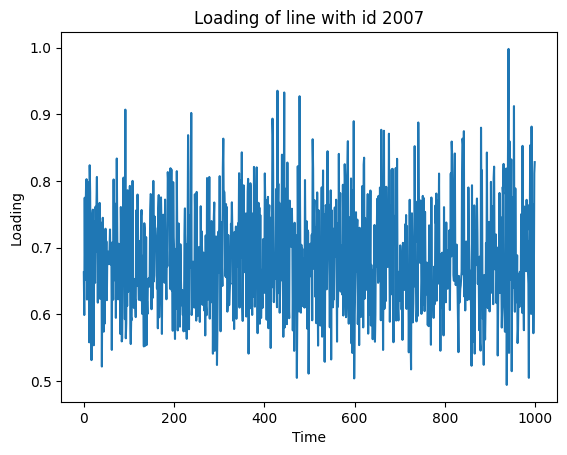

In [14]:
# Plot the loading of line with id 2007 vs time.
line_2007_idx = np.where(output_data["line"]["id"] == 2007)
result_loading = output_data["line"]["loading"][line_2007_idx]
plt.plot(result_loading)
plt.title('Loading of line with id 2007')
plt.xlabel('Time')
plt.ylabel('Loading')
plt.show()

## Indexing the results

Find the time stamps where loading in `line with id 2007` is greater than `90%`

In [15]:
# Times when loading of line with id 2007 when its greater than 90%
ind = np.where(result_loading > 0.9)
df_load_profile.index[ind]

DatetimeIndex(['2022-01-04 20:00:00', '2022-01-10 22:00:00',
               '2022-01-18 21:00:00', '2022-01-19 12:00:00',
               '2022-01-20 22:00:00', '2022-02-09 05:00:00',
               '2022-02-09 17:00:00'],
              dtype='datetime64[ns]', freq=None)

# Assignment 6: N-1 Scenario Batch Calculation

We want to run a N-1 Scenario analysis. For each batch calculation, one `line` is disconnected at from- and to-side.

In [16]:
n_lines = len(input_data["line"])

# Initialize an empty line profile
line_profile = initialize_array("update", "line", (n_lines, n_lines))

# Set the attributes for the batch calculation
line_profile["id"] =  input_data["line"]["id"]
line_profile["from_status"] = 1 - np.eye(n_lines, dtype=np.uint8)
line_profile["to_status"] = 1 - np.eye(n_lines, dtype=np.uint8)

# Construct the update data
update_data = {"line": line_profile}

In [17]:
# Validating batch data can take a long time.
# It is recommended to only validate batch data when you run into trouble.
with Timer("Validating Batch Data"):
    assert_valid_batch_data(input_data=input_data, update_data=update_data, calculation_type=CalculationType.power_flow)

Execution time for Validating Batch Data is 14.155806 s


In [18]:
# Run Newton Raphson power flow (this may take a minute...)
with Timer("Batch Calculation using Newton-Raphson"):
    model.calculate_power_flow(update_data=update_data, calculation_method=CalculationMethod.newton_raphson)

Execution time for Batch Calculation using Newton-Raphson is 18.678107 s


In [19]:
# Run linear power flow
with Timer("Batch Calculation using linear calculation"):
    model.calculate_power_flow(update_data=update_data, calculation_method=CalculationMethod.linear)

Execution time for Batch Calculation using linear calculation is 5.275714 s


## Parallel processing
The `calculate_power_flow` method has an optional `threading` argument to define the number of threads ran in parallel. Experiment with different threading values and compare the results...

In [ ]:
# By default, sequential threading is used
with Timer("Sequential"):
    model.calculate_power_flow(update_data=update_data)

# Single thread, this is essentially the same as running a single thread
with Timer("Single thread"):
    model.calculate_power_flow(update_data=update_data, threading=1)

# Two threads should be faster    
with Timer("Two threads in parallel"):
    model.calculate_power_flow(update_data=update_data, threading=2)

# Four threads should be even faster    
with Timer("Four threads in parallel"):
    model.calculate_power_flow(update_data=update_data, threading=4)

# Use number of threads based the machine hardware    
with Timer("Use number of threads based the machine hardware"):
    model.calculate_power_flow(update_data=update_data, threading=0)

Execution time for Sequential is 18.580412 s
Execution time for Single thread is 17.847914 s
Execution time for Two threads in parallel is 10.605476 s
Execution time for Four threads in parallel is 5.669301 s
